In [25]:
#Necessary Imports for Data Cleaning and Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd
pd.set_option('display.max_rows', None)

In [27]:
job_df = pd.read_csv('cleaned_fake_job_postings.csv')
job_df.shape

(17880, 74)

In [29]:
num_fake_jobs = job_df['fraudulent'].sum()
num_fake_jobs

866

In [31]:
#Industry Column
from sklearn.preprocessing import OneHotEncoder

# Initialize the encoder with drop='first' to remove the reference category
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Fit and transform the 'Standardized_Industry' column
encoded_array = encoder.fit_transform(job_df[['Standardized_Industry']])

# Convert the array into a DataFrame with named columns
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['Standardized_Industry']))

# Concatenate the original DataFrame with the encoded DataFrame
job_df = pd.concat([job_df, encoded_df], axis=1)

# Optionally, drop the original categorical column
job_df.drop(columns=['Standardized_Industry'], inplace=True)


In [33]:
#Department Column

# Fit and transform the 'Standardized_Industry' column
encoded_array = encoder.fit_transform(job_df[['Standardized_Department']])

# Convert the array into a DataFrame with named columns
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['Standardized_Department']))

# Concatenate the original DataFrame with the encoded DataFrame
job_df = pd.concat([job_df, encoded_df], axis=1)

# Optionally, drop the original categorical column
job_df.drop(columns=['Standardized_Department'], inplace=True)

In [35]:
job_df = job_df.loc[:, ~job_df.columns.duplicated()]

In [37]:
#Balancing the data
import pandas as pd
from sklearn.utils import resample

# Split data
fake_jobs = job_df[job_df['fraudulent'] == 1]  # Minority class (fake)
real_jobs = job_df[job_df['fraudulent'] == 0]  # Majority class (real)

# Define sampling strategy (e.g., real jobs = 2x fake jobs)
undersample_real = real_jobs.sample(n=2 * len(fake_jobs), random_state=42)  # Undersample real jobs
oversample_fake = resample(fake_jobs, replace=True, n_samples=len(undersample_real), random_state=42)  # Oversample fake jobs

# Combine into balanced dataset
balanced_df = pd.concat([undersample_real, oversample_fake])

# Verify balance
print(balanced_df['fraudulent'].value_counts())

fraudulent
0    1732
1    1732
Name: count, dtype: int64


In [39]:
balanced_df.shape

(3464, 72)

In [41]:
# Get all column names
print("All attributes/columns in balanced_df:")
print(balanced_df.columns.tolist())

All attributes/columns in balanced_df:
['job_id', 'title', 'location', 'department', 'Standardized_Department_Administrative', 'Standardized_Department_Business Consulting', 'Standardized_Department_Creative & Design', 'Standardized_Department_Customer Service', 'Standardized_Department_Education & Training', 'Standardized_Department_Engineering', 'Standardized_Department_Finance & Accounting', 'Standardized_Department_Government & Public Sector', 'Standardized_Department_Healthcare', 'Standardized_Department_Hospitality & Food Services', 'Standardized_Department_Human Resources', 'Standardized_Department_IT', 'Standardized_Department_Legal & Compliance', 'Standardized_Department_Logistics & Supply Chain', 'Standardized_Department_Manufacturing & Production', 'Standardized_Department_Marketing', 'Standardized_Department_Media & Communications', 'Standardized_Department_Not Provided', 'Standardized_Department_Operations', 'Standardized_Department_Product Management & Development', 'Stan

In [43]:
balanced_df.to_csv('balanced_df.csv', index=False)

In [45]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from itertools import combinations

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Load your DataFrame (assuming it's already created as balanced_df)
# balanced_df = pd.read_csv('your_file.csv')

# Separate numerical and categorical columns
numerical_cols = balanced_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = [col for col in balanced_df.columns if col not in numerical_cols]

# --- Numerical vs. Numerical (Pearson Correlation) ---
num_num_correlations = balanced_df[numerical_cols].corr(method='pearson')

# print("\nNumerical vs. Numerical Correlation (Pearson):\n", num_num_correlations)

# Identify highly correlated pairs (absolute value > 0.7)
high_num_num_corr = {}
for i, col in enumerate(numerical_cols):
    for j in range(i+1, len(numerical_cols)):
        col2 = numerical_cols[j]
        corr_val = num_num_correlations.loc[col, col2]
        if abs(corr_val) > 0.7:
            high_num_num_corr[(col, col2)] = corr_val

# print("\nHighly Correlated Numerical Pairs (Pearson > 0.7):\n", high_num_num_corr)

# --- Categorical vs. Categorical (Cramer's V) ---
cat_cat_correlations = {}
for col1, col2 in combinations(categorical_cols, 2):
    cat_cat_correlations[(col1, col2)] = cramers_v(balanced_df[col1], balanced_df[col2])

# print("\nCategorical vs. Categorical Correlation (Cramer's V):\n", cat_cat_correlations)

# Identify highly correlated pairs (Cramer's V > 0.7)
high_cat_cat_corr = {k: v for k, v in cat_cat_correlations.items() if v > 0.7}

# print("\nHighly Correlated Categorical Pairs (Cramer's V > 0.7):\n", high_cat_cat_corr)

# --- Numerical vs. Categorical ---

#For numerical vs categorical correlation, additional analysis is needed such as ANOVA or point-biserial correlation


In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Assuming your DataFrame is already loaded as balanced_df

# Identify Standardized Industry columns for dropping
industry_cols = [col for col in balanced_df.columns if col.startswith('Standardized_Industry')]

# Separate features (X) and target (y)
X = balanced_df.drop(['fraudulent', 'job_id'] + industry_cols, axis=1, errors='ignore')
y = balanced_df['fraudulent']

# Select only numeric features for PCA
X_numeric = X.select_dtypes(include=np.number)

# Handle missing values by filling with the mean
X_numeric = X_numeric.fillna(X_numeric.mean())

# Store the original attribute names before scaling
attribute_names = list(X_numeric.columns)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for the PCA components
pca_df = pd.DataFrame(data=X_pca, index=X_numeric.index, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# Reset indices to ensure they're unique before concatenation
pca_df = pca_df.reset_index(drop=True)
y = y.reset_index(drop=True)

# Concatenate PCA components with target variable
final_df = pd.concat([pca_df, y], axis=1)

# Calculate correlation between PCA components and target variable
correlations = final_df.corr()['fraudulent'].sort_values(ascending=False)

# Get loadings (correlation between original variables and PCs)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Create DataFrame to show attribute names with loadings for each PC
loadings_df = pd.DataFrame(loadings,
                         index=attribute_names,
                         columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# Ensure the index is unique
if not loadings_df.index.is_unique:
    loadings_df = loadings_df[~loadings_df.index.duplicated(keep='first')]

# Get the top 45 components
top_45_components = correlations[1:35].index.tolist()

# Find attributes with highest average absolute loading across top 45 components
avg_abs_loadings = loadings_df[top_45_components].abs().mean(axis=1)

# Get top 45 attributes
top_45_attributes = avg_abs_loadings.nlargest(45).index.tolist()

# Print the top 45 attributes
print("Top 34 attributes to consider for model training (excluding job_id and Standardized Industry):\n", top_45_attributes)

Top 34 attributes to consider for model training (excluding job_id and Standardized Industry):
 ['Standardized_Department_Project Management', 'Standardized_Department_Hospitality & Food Services', 'Standardized_Department_Product Management & Development', 'Standardized_Department_Government & Public Sector', 'Standardized_Department_Human Resources', 'Standardized_Department_Operations', 'Standardized_Department_Logistics & Supply Chain', 'Standardized_Department_Administrative', 'Standardized_Department_Education & Training', 'Standardized_Department_Customer Service', 'Standardized_Department_Research & Development', 'Standardized_Department_Retail & Consumer', 'Standardized_Department_Finance & Accounting', 'Standardized_Department_Healthcare', 'Standardized_Department_Quality Assurance & Testing', 'Standardized_Department_IT', 'Standardized_Department_Engineering', 'Standardized_Department_Technology', 'Standardized_Department_Creative & Design', 'Standardized_Department_Legal & 

In [49]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

top_45_attributes = [
    'Standardized_Department_Project Management',
    'Standardized_Department_Hospitality & Food Services', 
    'Standardized_Department_Product Management & Development', 
    'Standardized_Department_Government & Public Sector', 
    'Standardized_Department_Human Resources',
    'Standardized_Department_Operations', 
    'Standardized_Department_Logistics & Supply Chain', 
    'Standardized_Department_Administrative',
    'Standardized_Department_Education & Training', 
    'Standardized_Department_Customer Service',
    'Standardized_Department_Research & Development',
    'Standardized_Department_Retail & Consumer',
    'Standardized_Department_Finance & Accounting',
    'Standardized_Department_Healthcare',
    'Standardized_Department_Quality Assurance & Testing',
    'Standardized_Department_IT',
    'Standardized_Department_Engineering',
    'Standardized_Department_Technology',
    'Standardized_Department_Creative & Design', 
    'Standardized_Department_Legal & Compliance', 
    'Standardized_Department_Marketing',
    'Standardized_Department_Media & Communications',
    'Standardized_Department_Business Consulting',
    'employment_encoded',
    'salary_diff',
    'Standardized_Department_Manufacturing & Production', 
    'has_questions', 'has_company_logo',
    'telecommuting', 'job_desc_length',
    'education_encoded', 
    'Standardized_Department_Sales', 
    'experience_encoded', 
    'Standardized_Department_Not Provided'

]

filtered_df = balanced_df[top_45_attributes + ['fraudulent']]

# Split into train, validation, and test sets (70/15/15 split)
train_df, temp_df = train_test_split(filtered_df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Separate features and target for each set
X_train = train_df.drop('fraudulent', axis=1)
y_train = train_df['fraudulent']

X_val = val_df.drop('fraudulent', axis=1)
y_val = val_df['fraudulent']

X_test = test_df.drop('fraudulent', axis=1)
y_test = test_df['fraudulent']

# Impute missing values (using mean strategy)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

# Initialize XGBoost model
xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False,
    # You can add other hyperparameters here
    # n_estimators=100,
    # max_depth=3,
    # learning_rate=0.1
)

# Train the model
xgb_model.fit(X_train_imputed, y_train)

# Evaluate on validation set
y_val_pred = xgb_model.predict(X_val_imputed)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Evaluate on test set (final evaluation)
y_test_pred = xgb_model.predict(X_test_imputed)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

# Feature importance
importance = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10))

joblib.dump(xgb_model, 'xgb_fraud_model.pkl')
print("Model saved as xgb_fraud_model.pkl")

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [12:20:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.8923

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       265
           1       0.85      0.94      0.90       255

    accuracy                           0.89       520
   macro avg       0.90      0.89      0.89       520
weighted avg       0.90      0.89      0.89       520


Test Accuracy: 0.8808

Test Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       283
           1       0.85      0.89      0.87       237

    accuracy                           0.88       520
   macro avg       0.88      0.88      0.88       520
weighted avg       0.88      0.88      0.88       520


Top 10 Most Important Features:
                                              Feature  Importance
27                                   has_company_logo    0.339899
16                Standardized_Department_Engineering    0.079817


In [42]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_df, test_df = train_test_split(balanced_df, train_size=0.7, test_size=0.3)

test_df, val_df = train_test_split(test_df, train_size=0.5, test_size=0.5)

In [66]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Assuming your DataFrame is already loaded as balanced_df
# Separate features (X) and target (y)
X = balanced_df.drop('fraudulent', axis=1)  # Drop the target variable
y = balanced_df['fraudulent']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)  # Adjust test_size and random_state as needed

# Drop non-numeric columns before imputation
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_val_numeric = X_val.select_dtypes(include=[np.number])

# Impute missing numeric values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_numeric)
X_val_imputed = imputer.transform(X_val_numeric)

# Convert imputed arrays back to DataFrames
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train_numeric.columns)
X_val_imputed = pd.DataFrame(X_val_imputed, columns=X_val_numeric.columns)

# Display the first few rows of the imputed DataFrames
print("X_train_imputed:\n", X_train_imputed.head())
print("\nX_val_imputed:\n", X_val_imputed.head())

X_train_imputed shape: (2771, 34)
Columns in X_train_imputed: ['Standardized_Department_Project Management', 'Standardized_Department_Hospitality & Food Services', 'Standardized_Department_Product Management & Development', 'Standardized_Department_Government & Public Sector', 'Standardized_Department_Human Resources', 'Standardized_Department_Operations', 'Standardized_Department_Logistics & Supply Chain', 'Standardized_Department_Administrative', 'Standardized_Department_Education & Training', 'Standardized_Department_Customer Service', 'Standardized_Department_Research & Development', 'Standardized_Department_Retail & Consumer', 'Standardized_Department_Finance & Accounting', 'Standardized_Department_Healthcare', 'Standardized_Department_Quality Assurance & Testing', 'Standardized_Department_IT', 'Standardized_Department_Engineering', 'Standardized_Department_Technology', 'Standardized_Department_Creative & Design', 'Standardized_Department_Legal & Compliance', 'Standardized_Departm

In [68]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [70]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

xgb_model.fit(X_train_imputed, y_train)


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [01:33:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Assuming your DataFrame is already loaded as balanced_df
# Separate features (X) and target (y)
X = balanced_df.drop('fraudulent', axis=1)
y = balanced_df['fraudulent']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Select only numeric features for imputation
X_train_numeric = X_train.select_dtypes(include=np.number)
X_val_numeric = X_val.select_dtypes(include=np.number)

# Impute missing numeric values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_numeric)
X_val_imputed = imputer.transform(X_val_numeric)

# Convert back to DataFrames (optional, but good practice)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train_numeric.columns)
X_val_imputed = pd.DataFrame(X_val_imputed, columns=X_val_numeric.columns)

# Initialize and train the XGBoost model
xgb_model = XGBClassifier(random_state=42)  # You can adjust hyperparameters as needed
xgb_model.fit(X_train_imputed, y_train)

# Make predictions on the validation set
y_val_pred = xgb_model.predict(X_val_imputed)

# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
print(f"XGBoost Validation Accuracy: {accuracy:.4f}")


XGBoost Validation Accuracy: 0.9380


Confusion Matrix:
[[345  25]
 [ 18 305]]


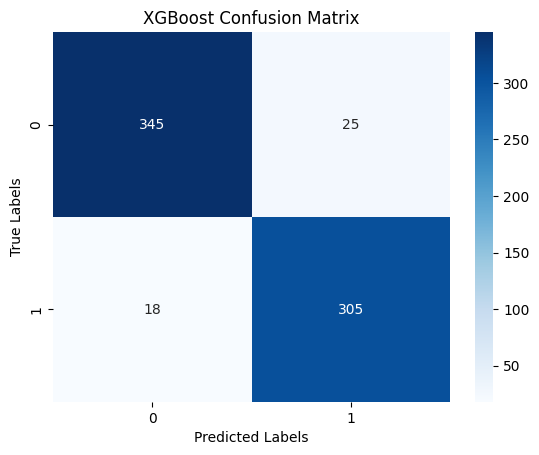

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the validation set
y_val_pred = xgb_model.predict(X_val_imputed)

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('XGBoost Confusion Matrix')
plt.show()


In [79]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Assuming your DataFrame is already loaded as balanced_df

# Separate features (X) and target (y)
X = balanced_df.drop(['fraudulent', 'job_id'], axis=1, errors='ignore')  # Drop the target variable and 'job_id'
y = balanced_df['fraudulent']

# Select only numeric features
X_numeric = X.select_dtypes(include=[np.number])

# Split data into training and testing with only numeric features
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
    'reg_alpha': [0.01, 0.1, 1, 10, 100],
    'reg_lambda': [0.01, 0.1, 1, 10, 100]
}

# Initialize XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter combinations to try
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit RandomizedSearchCV to the data
random_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best accuracy found: ", random_search.best_score_)

# Evaluate on test set
best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [01:12:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters found:  {'subsample': 0.8, 'reg_lambda': 10, 'reg_alpha': 0.01, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.3}
Best accuracy found:  0.8787425407143717
Test accuracy: 0.8874


In [31]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

# Instantiate Model
logr = LogisticRegression(warm_start=True, max_iter=5000, solver='saga')

# Get data from TRAINING SET of BALANCED DF
feature_columns = train_df.drop(
    columns=['fraudulent', 'salary_range', 'job_id'] +
             train_df.filter(like='Standardized_Department').columns.tolist()
).select_dtypes(include=['int64', 'float64']).columns
X_train = train_df[feature_columns]
y_train = train_df['fraudulent']

# Get data from VALIDATION SET of BALANCED DF
X_val = val_df[feature_columns]
y_val = val_df['fraudulent']

# Impute missing values using the mean
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)

# Fit Model
logr.fit(X_train, y_train)

# Now you should be able to access the coefficients
# Ensure feature_columns and logr.coef_[0] have the same length
feature_importance = pd.DataFrame({'Feature': feature_columns, 'Coefficient': logr.coef_[0][:len(feature_columns)]})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)
print(feature_importance)

                                         Feature   Coefficient
0                                    salary_diff  1.913474e-08
25            Standardized_Industry_Not Provided  6.275448e-09
17                 Standardized_Industry_Finance  1.746759e-09
26             Standardized_Industry_Real Estate  1.094910e-09
2                                  telecommuting  1.091444e-09
14             Standardized_Industry_Engineering  1.184523e-10
8               Standardized_Industry_Automotive  8.883207e-11
29          Standardized_Industry_Transportation  8.879587e-11
16  Standardized_Industry_Environmental Services  2.972384e-11
28                Standardized_Industry_Security  0.000000e+00
18              Standardized_Industry_Government  0.000000e+00
7              Standardized_Industry_Agriculture -2.955497e-11
15           Standardized_Industry_Entertainment -2.958250e-11
23                   Standardized_Industry_Media -1.478399e-10
24               Standardized_Industry_Nonprofit -1.479

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [27]:
from sklearn.metrics import accuracy_score

# Predict class labels
y_val_pred = logr.predict(X_val)

# Compute accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print Results
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.5288


In [33]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

# ... (rest of your imports)

# Assuming 'logr' is your trained model and 'feature_columns' is defined
# during training as:
feature_columns = train_df.drop(
     columns=['fraudulent', 'salary_range', 'job_id'] +
              train_df.filter(like='Standardized_Department').columns.tolist()
 ).select_dtypes(include=['int64', 'float64']).columns

# Get data from VALIDATION SET of BALANCED DF, using the SAME feature_columns
X_val = val_df[feature_columns]  # Ensure consistency with training data
y_val = val_df['fraudulent']

# Impute missing values using the SAME imputer fitted on training data
# Assuming you have already fitted an imputer: imputer = SimpleImputer(strategy='mean')
X_val = imputer.transform(X_val)  # Use the same imputer

# Predict class labels
y_val_pred = logr.predict(X_val)

# Compute accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print Results
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.5288


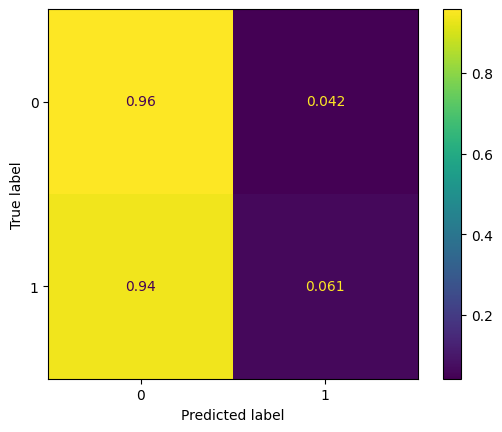

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer

# Assuming 'feature_columns' is defined as in your training code
X_test = test_df[feature_columns]  # Select the same features used for training
# Impute missing values using the mean (using the imputer fitted on training data)
X_test = imputer.transform(X_test)

# Get the true labels for the test set
y_test = test_df['fraudulent']  # Assuming 'fraudulent' is your target column

y_pred = logr.predict(X_test)  # Predict on the transformed test data

ConfusionMatrixDisplay.from_predictions(
   y_test, y_pred, normalize='true')

In [75]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score


def evaluate_top_features(model, train_df, val_df, coef_threshold=0.1):
    """
    Fits logistic regression models for individual features and all features,
    evaluates their accuracy on the validation set, and prints the results.

    Parameters:
    - model: Trained logistic regression model
    - train_df: Training dataset (DataFrame)
    - val_df: Validation dataset (DataFrame)
    - coef_threshold: Minimum absolute coefficient value to include a feature
    """

    # Prepare training and validation data
    X_train_df = train_df.drop(
        columns=['fraudulent', 'salary_range', 'job_id'] +
                 train_df.filter(like='Standardized_Department').columns.tolist()
    ).select_dtypes(include=['int64', 'float64'])  # Keep as DataFrame
    y_train = train_df['fraudulent']

    X_val_df = val_df.drop(
        columns=['fraudulent', 'salary_range', 'job_id'] +
                 train_df.filter(like='Standardized_Department').columns.tolist()
    ).select_dtypes(include=['int64', 'float64'])  # Keep as DataFrame
    y_val = val_df['fraudulent']

    # Create and Fit an Imputer
    # Get numeric columns explicitly to avoid 'salary_diff'
    numeric_cols = X_train_df.select_dtypes(include=np.number).columns
    imputer = SimpleImputer(strategy='mean')
    X_train_df[numeric_cols] = imputer.fit_transform(X_train_df[numeric_cols])
    X_val_df[numeric_cols] = imputer.transform(X_val_df[numeric_cols])

    # Fit the model on the full training set to get coefficients
    model.fit(X_train_df, y_train)

    # Extract coefficients and feature names from the original DataFrame
    coef_df = pd.DataFrame({
        'Feature': X_train_df.columns,
        'Coefficient': model.coef_.flatten()
    })

    # Filter features above the coefficient threshold
    significant_features = coef_df[coef_df['Coefficient'].abs() >= coef_threshold]

    # Sort coefficients in descending order
    significant_features = significant_features.sort_values(by="Coefficient", ascending=False)

    print(f"\nFeatures with coefficients >= {coef_threshold}:\n", significant_features)

    # Track accuracy scores
    accuracy_scores = {}

    # Iterate over selected features and fit a logistic regression model for each
    for feature in significant_features['Feature']:
        # Extracting the feature from the imputed DataFrames
        X_train_subset = X_train_df[[feature]]
        X_val_subset = X_val_df[[feature]]

        temp_model = LogisticRegression()
        temp_model.fit(X_train_subset, y_train)

        # Predict on validation data
        y_val_pred = temp_model.predict(X_val_subset)
        accuracy = accuracy_score(y_val, y_val_pred)
        accuracy_scores[feature] = accuracy

        print(f"Feature: {feature} | Validation Accuracy: {accuracy:.4f}")

    # --- Additional code to evaluate overall model accuracy ---

    # Predict on validation data using the original model (with all features)
    y_val_pred_all_features = model.predict(X_val_df)  # Use X_val_df here
    accuracy_all_features = accuracy_score(y_val, y_val_pred_all_features)

    print(f"\nOverall Model Accuracy (with all features): {accuracy_all_features:.4f}")

    # Sort features by accuracy
    sorted_features = sorted(accuracy_scores.items(), key=lambda x: x[1], reverse=True)

    # Print sorted accuracy results
    print("\nSorted Accuracy Scores:")
    for feature, acc in sorted_features:
        print(f"Feature: {feature} | Accuracy: {acc:.4f}")

In [77]:
#0.1 Threshold
logr = LogisticRegression(warm_start=True, max_iter=10000)
evaluate_top_features(logr, train_df, val_df)


Features with coefficients >= 0.1:
                                          Feature  Coefficient
26             Standardized_Industry_Real Estate     1.801217
17                 Standardized_Industry_Finance     0.964310
8               Standardized_Industry_Automotive     0.791213
29          Standardized_Industry_Transportation     0.787220
25            Standardized_Industry_Not Provided     0.660448
14             Standardized_Industry_Engineering     0.492805
16  Standardized_Industry_Environmental Services     0.445724
2                                  telecommuting     0.372006
22               Standardized_Industry_Marketing     0.359566
7              Standardized_Industry_Agriculture     0.151230
23                   Standardized_Industry_Media     0.148111
27                  Standardized_Industry_Retail     0.109491
4                                  has_questions    -0.114000
11          Standardized_Industry_Consumer Goods    -0.197932
24               Standardized_Ind

In [41]:
#0.3 Threshold
logr = LogisticRegression(warm_start=True, max_iter=10000)
evaluate_top_features(logr, train_df, val_df, coef_threshold=0.3)


Features with coefficients >= 0.3:
                                          Feature  Coefficient
26             Standardized_Industry_Real Estate     1.801217
17                 Standardized_Industry_Finance     0.964310
8               Standardized_Industry_Automotive     0.791213
29          Standardized_Industry_Transportation     0.787220
25            Standardized_Industry_Not Provided     0.660448
14             Standardized_Industry_Engineering     0.492805
16  Standardized_Industry_Environmental Services     0.445724
2                                  telecommuting     0.372006
22               Standardized_Industry_Marketing     0.359566
24               Standardized_Industry_Nonprofit    -0.367558
21                     Standardized_Industry_Law    -0.468769
9             Standardized_Industry_Construction    -0.573460
19             Standardized_Industry_Health Care    -0.587387
10              Standardized_Industry_Consulting    -0.653847
12               Standardized_Ind

In [42]:
#0.05 Threshold
logr = LogisticRegression(warm_start=True, max_iter=10000)
evaluate_top_features(logr, train_df, val_df, coef_threshold=0.05)


Features with coefficients >= 0.05:
                                          Feature  Coefficient
26             Standardized_Industry_Real Estate     1.801217
17                 Standardized_Industry_Finance     0.964310
8               Standardized_Industry_Automotive     0.791213
29          Standardized_Industry_Transportation     0.787220
25            Standardized_Industry_Not Provided     0.660448
14             Standardized_Industry_Engineering     0.492805
16  Standardized_Industry_Environmental Services     0.445724
2                                  telecommuting     0.372006
22               Standardized_Industry_Marketing     0.359566
7              Standardized_Industry_Agriculture     0.151230
23                   Standardized_Industry_Media     0.148111
27                  Standardized_Industry_Retail     0.109491
6                              education_encoded     0.050476
4                                  has_questions    -0.114000
11          Standardized_Industr

In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    """
    Computes Variance Inflation Factor (VIF) for each feature in the DataFrame.

    Parameters:
    - df: pandas DataFrame containing only the independent variables

    Returns:
    - DataFrame with features and their VIF scores
    """
    # Select only numeric features
    numeric_df = df.select_dtypes(include=['int64', 'float64']).replace([np.inf, -np.inf], np.nan).dropna()

    vif_data = pd.DataFrame()
    vif_data["Feature"] = numeric_df.columns
    vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i) for i in range(numeric_df.shape[1])]

    return vif_data.sort_values(by="VIF", ascending=False)

In [47]:
X_train_numeric = balanced_df.drop(columns=['fraudulent'])  # Drop target variable
vif_scores = calculate_vif(X_train_numeric)

# Display VIF scores
print(vif_scores)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                              Feature           VIF
56               Standardized_Industry_Transportation           inf
41                  Standardized_Industry_Engineering           inf
26                 Standardized_Department_Technology           inf
54                       Standardized_Industry_Retail           inf
1              Standardized_Department_Administrative           inf
35                   Standardized_Industry_Automotive           inf
36                 Standardized_Industry_Construction           inf
37                   Standardized_Industry_Consulting           inf
38               Standardized_Industry_Consumer Goods           inf
39                    Standardized_Industry_Education           inf
40                  Standardized_Industry_Electronics           inf
42                Standardized_Industry_Entertainment           inf
24          Standardized_Department_Retail & Consumer           inf
43       Standardized_Industry_Environmental Ser

In [49]:
from sklearn.metrics import confusion_matrix, precision_score

# Assuming you already trained your model and have validation data
y_pred = logr.predict(X_val)  # Model predictions on validation set
y_true = y_val  # Actual labels from validation set

# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Calculate rates
tpr = tp / (tp + fn)  # True Positive Rate (Recall or Sensitivity)
tnr = tn / (tn + fp)  # True Negative Rate (Specificity)
fpr = fp / (fp + tn)  # False Positive Rate
fnr = fn / (fn + tp)  # False Negative Rate
precision = precision_score(y_true, y_pred)  # Precision

# Print results
print("Accuracy Metrics for Model with Dropped Department")
print(f"True Positive Rate (TPR / Recall): {tpr:.4f}")
print(f"True Negative Rate (TNR / Specificity): {tnr:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")
print(f"Precision: {precision:.4f}")


Accuracy Metrics for Model with Dropped Department
True Positive Rate (TPR / Recall): 0.6693
True Negative Rate (TNR / Specificity): 0.8158
False Positive Rate (FPR): 0.1842
False Negative Rate (FNR): 0.3307
Precision: 0.7763


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [51]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

# Drop unnecessary columns from train and validation datasets
X_train_df = train_df.drop(
    columns=['fraudulent', 'salary_range', 'job_id'] +
                 train_df.filter(like='Standardized_Department').columns.tolist()
    ).select_dtypes(include=['int64', 'float64'])
y_train = train_df['fraudulent']

X_val_df = val_df.drop(
        columns=['fraudulent', 'salary_range', 'job_id'] +
                 train_df.filter(like='Standardized_Department').columns.tolist()
    ).select_dtypes(include=['int64', 'float64'])
y_val = val_df['fraudulent']

# # Define feature columns after dropping unnecessary ones
# feature_columns = train_df.drop(columns=['fraudulent', 'salary_range', 'job_id']).select_dtypes(
#     include=['int64', 'float64']
# ).columns

# Standardize the features
scaler = StandardScaler()

# Impute missing values using SimpleImputer before scaling
imputer = SimpleImputer(strategy='mean')  # or other strategy
scaled_train_features = scaler.fit_transform(imputer.fit_transform(train_df[feature_columns]))

# Apply PCA (keep enough components to explain 95% of variance)
pca = PCA(n_components=0.95)
pca_train_features = pca.fit_transform(scaled_train_features)

# Convert PCA result back to a DataFrame
pca_train_df = pd.DataFrame(data=pca_train_features, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# Train Logistic Regression model
logr = LogisticRegression()
logr.fit(pca_train_df, train_df['fraudulent'])  # Assuming 'fraudulent' is the target column

# Transform validation dataset using the same preprocessing
# Impute missing values in validation set before scaling
scaled_val_features = scaler.transform(imputer.transform(val_df[feature_columns]))
pca_val_features = pca.transform(scaled_val_features)

# Predict class labels on validation set
y_val_pred = logr.predict(pca_val_features)

# Compute validation accuracy
val_accuracy = accuracy_score(val_df['fraudulent'], y_val_pred)

# Compute confusion matrix components
tn, fp, fn, tp = confusion_matrix(val_df['fraudulent'], y_val_pred).ravel()

# Calculate accuracy metrics
tpr = tp / (tp + fn)  # True Positive Rate (Recall)
tnr = tn / (tn + fp)  # True Negative Rate (Specificity)
fpr = fp / (fp + tn)  # False Positive Rate
fnr = fn / (fn + tp)  # False Negative Rate
precision = precision_score(val_df['fraudulent'], y_val_pred)

# Print results
print("Accuracy Metrics w/ PCA (Dropped Industry)")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"True Positive Rate (TPR / Recall): {tpr:.4f}")
print(f"True Negative Rate (TNR / Specificity): {tnr:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")
print(f"Precision: {precision:.4f}")

Accuracy Metrics w/ PCA (Dropped Industry)
Validation Accuracy: 0.7538
True Positive Rate (TPR / Recall): 0.7244
True Negative Rate (TNR / Specificity): 0.7820
False Positive Rate (FPR): 0.2180
False Negative Rate (FNR): 0.2756
Precision: 0.7603


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [53]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.impute import SimpleImputer
import pandas as pd

def pca_logistic_regression(train_df, val_df, feature_columns):
    """
    Applies PCA to the specified features, trains a logistic regression model,
    and evaluates it on the validation set.

    Args:
        train_df (pd.DataFrame): Training dataset.
        val_df (pd.DataFrame): Validation dataset.
        feature_columns (list): List of feature column names.

    Returns:
        dict: Dictionary containing accuracy metrics.
    """

    # Create an imputer to handle missing values
    imputer = SimpleImputer(strategy='mean')  # or other strategies like 'median', 'most_frequent'

    # Fit and transform the imputer on your training data
    train_df_imputed = pd.DataFrame(imputer.fit_transform(train_df[feature_columns]), columns=feature_columns)

    # Standardize the features using the imputed data
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(train_df_imputed)

    # Apply PCA
    pca = PCA(n_components=0.95)  # Keep enough components to explain 95% of variance
    pca_features = pca.fit_transform(scaled_features)

    # Convert PCA result back to a DataFrame
    pca_df = pd.DataFrame(data=pca_features, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

    # Train a logistic regression model on the PCA-transformed data
    model = LogisticRegression()
    model.fit(pca_df, train_df['fraudulent'])  # Assuming 'fraudulent' is the target column

    # Transform validation dataset using the same preprocessing
    # Impute missing values in validation set before scaling
    val_df_imputed = pd.DataFrame(imputer.transform(val_df[feature_columns]), columns=feature_columns)
    scaled_val_features = scaler.transform(val_df_imputed)
    pca_val_features = pca.transform(scaled_val_features)

    # Make predictions
    val_preds = model.predict(pca_val_features)

    # Calculate accuracy metrics
    accuracy = accuracy_score(val_df['fraudulent'], val_preds)
    precision = precision_score(val_df['fraudulent'], val_preds)
    recall = recall_score(val_df['fraudulent'], val_preds)
    tn, fp, fn, tp = confusion_matrix(val_df['fraudulent'], val_preds).ravel()
    tpr = tp / (tp + fn)  # True Positive Rate (Recall)
    tnr = tn / (tn + fp)  # True Negative Rate (Specificity)
    fpr = fp / (fp + tn)  # False Positive Rate
    fnr = fn / (fn + tp)  # False Negative Rate

    # Print the explained variance ratio for each principal component
    print("Explained variance ratio for each principal component:")
    for i, variance in enumerate(pca.explained_variance_ratio_):
        print(f"Principal Component {i+1}: {variance:.4f}")

    # Print the feature column names and their contributions to each principal component
    loadings_df = pd.DataFrame(pca.components_, columns=feature_columns)
    print("\nFeature Contributions to Principal Components:")
    for i in range(loadings_df.shape[0]):
        print(f"\nPrincipal Component {i+1}:")
        for j in range(len(feature_columns)):
            print(f"  {feature_columns[j]}: {loadings_df.iloc[i, j]:.4f}")

    # Return the metrics
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'tpr': tpr,
        'tnr': tnr,
        'fpr': fpr,
        'fnr': fnr
    }


In [55]:
metrics = pca_logistic_regression(train_df, val_df, feature_columns)
print(metrics)

Explained variance ratio for each principal component:
Principal Component 1: 0.0865
Principal Component 2: 0.0530
Principal Component 3: 0.0486
Principal Component 4: 0.0434
Principal Component 5: 0.0396
Principal Component 6: 0.0387
Principal Component 7: 0.0372
Principal Component 8: 0.0366
Principal Component 9: 0.0366
Principal Component 10: 0.0363
Principal Component 11: 0.0361
Principal Component 12: 0.0360
Principal Component 13: 0.0360
Principal Component 14: 0.0360
Principal Component 15: 0.0359
Principal Component 16: 0.0359
Principal Component 17: 0.0359
Principal Component 18: 0.0358
Principal Component 19: 0.0358
Principal Component 20: 0.0357
Principal Component 21: 0.0344
Principal Component 22: 0.0328
Principal Component 23: 0.0302
Principal Component 24: 0.0254
Principal Component 25: 0.0242

Feature Contributions to Principal Components:

Principal Component 1:
  salary_diff: -0.0100
  job_desc_length: -0.0702
  telecommuting: 0.0590
  has_company_logo: -0.3688
  has

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


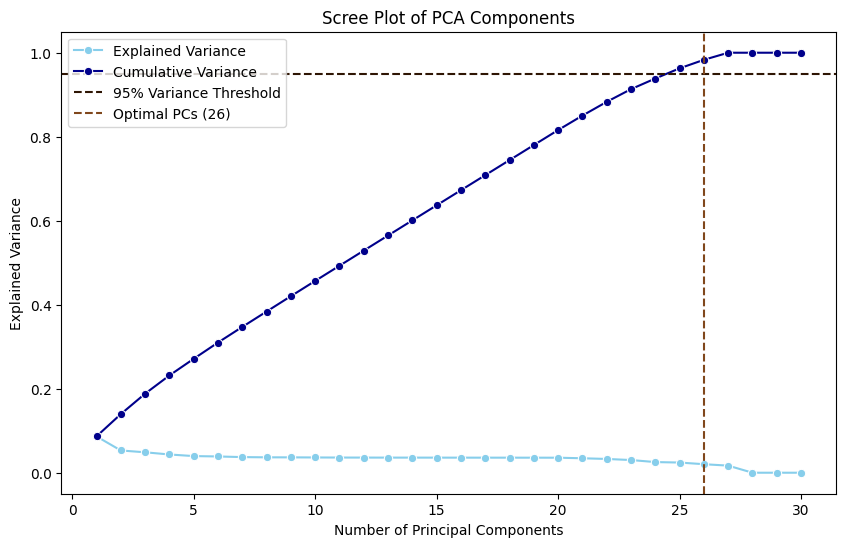

<Figure size 640x480 with 0 Axes>

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Handle missing values using imputation
imputer = SimpleImputer(strategy='mean')  # Replace NaNs with column means
imputed_features = imputer.fit_transform(train_df[feature_columns])

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(imputed_features)

# Apply PCA
pca = PCA()
pca.fit(scaled_features)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot Scree Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(explained_variance) + 1), y=explained_variance, marker='o', color='skyblue', label='Explained Variance')
sns.lineplot(x=range(1, len(explained_variance) + 1), y=cumulative_variance, marker='o', color='darkblue', label='Cumulative Variance')

# Add reference lines
plt.axhline(y=0.95, color='#2e1503', linestyle='dashed', label="95% Variance Threshold")  # Red dashed line at 95%
plt.axvline(x=26, color='#80471c', linestyle='dashed', label="Optimal PCs (26)")  # Green dashed line at 26 PCs

# Labels and Title
plt.xlabel("Number of Principal Components")
plt.ylabel("Explained Variance")
plt.title("Scree Plot of PCA Components")
plt.legend()
plt.figure(facecolor=(246/255, 246/255, 246/255))

# Show plot
plt.show()

In [59]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.impute import SimpleImputer

def test_pca_with_different_components(train_df, val_df, feature_columns, n_components_list):
    """
    Tests different PCA components and evaluates model performance.

    Args:
        train_df (pd.DataFrame): Training dataset.
        val_df (pd.DataFrame): Validation dataset.
        feature_columns (list): List of feature column names.
        n_components_list (list): List of n_components values to test.

    Returns:
        pd.DataFrame: DataFrame containing performance metrics for each n_components.
    """
    # Create an imputer to handle missing values
    imputer = SimpleImputer(strategy='mean')

    # Impute and scale the training data
    train_df_imputed = pd.DataFrame(imputer.fit_transform(train_df[feature_columns]), columns=feature_columns)
    scaler = StandardScaler()
    scaled_train_features = scaler.fit_transform(train_df_imputed)

    # List to store performance metrics
    metrics_list = []

    for n_components in n_components_list:
        # Apply PCA
        pca = PCA(n_components=n_components)
        pca_features = pca.fit_transform(scaled_train_features)

        # Train a logistic regression model
        model = LogisticRegression()
        model.fit(pca_features, train_df['fraudulent'])

        # Impute and scale the validation data
        val_df_imputed = pd.DataFrame(imputer.transform(val_df[feature_columns]), columns=feature_columns)
        scaled_val_features = scaler.transform(val_df_imputed)
        pca_val_features = pca.transform(scaled_val_features)

        # Make predictions
        val_preds = model.predict(pca_val_features)

        # Calculate metrics
        accuracy = accuracy_score(val_df['fraudulent'], val_preds)
        precision = precision_score(val_df['fraudulent'], val_preds)
        tn, fp, fn, tp = confusion_matrix(val_df['fraudulent'], val_preds).ravel()
        tpr = tp / (tp + fn)  # True Positive Rate (Recall)
        tnr = tn / (tn + fp)  # True Negative Rate (Specificity)
        fpr = fp / (fp + tn)  # False Positive Rate
        fnr = fn / (fn + tp)  # False Negative Rate

        # Append the metrics to the list
        metrics_list.append({
            "n_components": n_components,
            "accuracy": accuracy,
            "precision": precision,
            "tpr": tpr,
            "tnr": tnr,
            "fpr": fpr,
            "fnr": fnr
        })

    # Create a DataFrame from the list of metrics
    metrics_df = pd.DataFrame(metrics_list)

    return metrics_df

# Define the range of n_components to test
n_components_list = range(1, 30)  # Adjust this range as needed

# Run the testing function
performance_metrics = test_pca_with_different_components(train_df, val_df, feature_columns, n_components_list)

# Print the performance metrics
print(performance_metrics)


    n_components  accuracy  precision       tpr       tnr       fpr       fnr
0              1  0.636538   0.627451  0.629921  0.642857  0.357143  0.370079
1              2  0.682692   0.660650  0.720472  0.646617  0.353383  0.279528
2              3  0.705769   0.686347  0.732283  0.680451  0.319549  0.267717
3              4  0.701923   0.684015  0.724409  0.680451  0.319549  0.275591
4              5  0.707692   0.687500  0.736220  0.680451  0.319549  0.263780
5              6  0.701923   0.680000  0.736220  0.669173  0.330827  0.263780
6              7  0.703846   0.682482  0.736220  0.672932  0.327068  0.263780
7              8  0.700000   0.680147  0.728346  0.672932  0.327068  0.271654
8              9  0.700000   0.680147  0.728346  0.672932  0.327068  0.271654
9             10  0.707692   0.690299  0.728346  0.687970  0.312030  0.271654
10            11  0.703846   0.685185  0.728346  0.680451  0.319549  0.271654
11            12  0.705769   0.687732  0.728346  0.684211  0.315

In [61]:
# Transform the training data
pca = PCA(n_components=23)
pca_train_features = pca.fit_transform(scaled_train_features)

# Transform the validation data
pca_val_features = pca.transform(scaled_val_features)

In [63]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

# Train your logistic regression model
logr = LogisticRegression()
logr.fit(pca_train_features, train_df['fraudulent'])

# Make predictions on the validation set
val_preds = logr.predict(pca_val_features)

# Calculate accuracy
accuracy = accuracy_score(val_df['fraudulent'], val_preds)

# Calculate precision
precision = precision_score(val_df['fraudulent'], val_preds)

# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(val_df['fraudulent'], val_preds).ravel()

# Calculate TNR, TPR, FPR, and FNR
tnr = tn / (tn + fp)  # True Negative Rate (Specificity)
tpr = tp / (tp + fn)  # True Positive Rate (Recall)
fpr = fp / (fp + tn)  # False Positive Rate
fnr = fn / (fn + tp)  # False Negative Rate

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"TNR: {tnr}")
print(f"TPR: {tpr}")
print(f"FPR: {fpr}")
print(f"FNR: {fnr}")


Accuracy: 0.7230769230769231
Precision: 0.7007299270072993
TNR: 0.6917293233082706
TPR: 0.7559055118110236
FPR: 0.3082706766917293
FNR: 0.2440944881889764


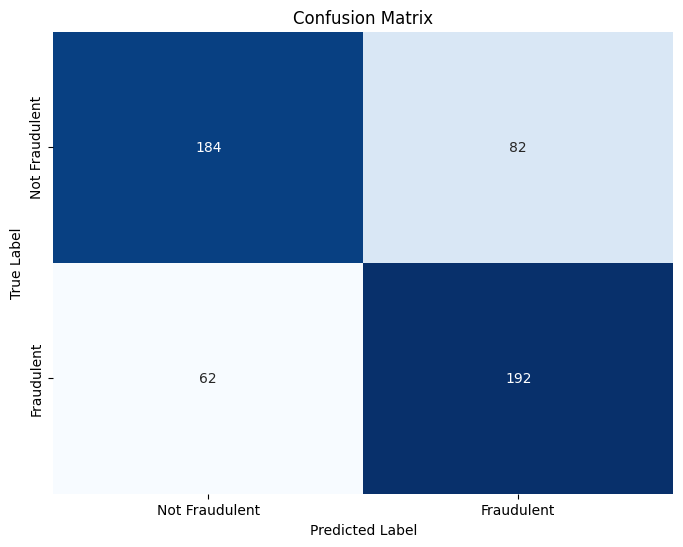

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(val_df['fraudulent'], val_preds)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Fraudulent', 'Fraudulent'],
            yticklabels=['Not Fraudulent', 'Fraudulent'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

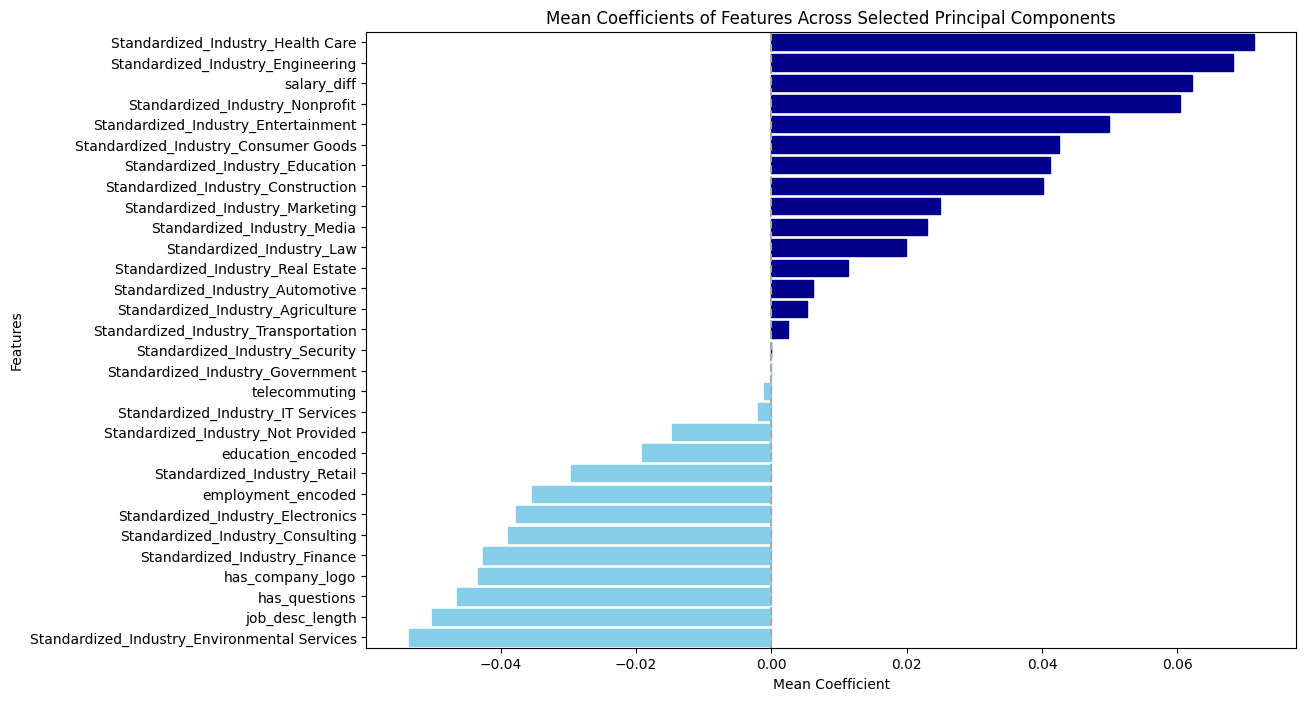

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `pca.components_` contains the PCA coefficients and `feature_columns` holds the names of features
# Flatten the coefficients for the features
coefficients = pd.DataFrame(pca.components_, columns=feature_columns)

# Create a DataFrame to hold the mean coefficients for each feature across the selected principal components
# Only use the first 23 components as per your decision
mean_coeffs = coefficients[:23].mean(axis=0).reset_index()
mean_coeffs.columns = ['Feature', 'Mean Coefficient']

# Sort the features by their mean coefficient
mean_coeffs = mean_coeffs.sort_values(by='Mean Coefficient', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
bars = sns.barplot(x='Mean Coefficient', y='Feature', data=mean_coeffs)

# Manually set bar colors (green for negative, red for positive)
for bar, coeff in zip(bars.patches, mean_coeffs['Mean Coefficient']):
    bar.set_color('skyblue' if coeff < 0 else 'darkblue')

# Titles and labels
plt.title('Mean Coefficients of Features Across Selected Principal Components')
plt.xlabel('Mean Coefficient')
plt.ylabel('Features')

# Vertical reference line at 0
plt.axvline(0, color='darkgrey', linestyle='--')

# Remove grid lines
plt.grid(False)

# Show plot
plt.show()


In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Step 1: Impute missing values in the test set
test_df_imputed = pd.DataFrame(imputer.transform(test_df[feature_columns]), columns=feature_columns)

# Step 2: Standardize the features in the test set
scaled_test_features = scaler.transform(test_df_imputed)

# Step 3: Transform the standardized test features using the PCA model
pca_test_features = pca.transform(scaled_test_features)

# Step 4: Make predictions on the PCA-transformed test set
test_preds = logr.predict(pca_test_features)

# Step 5: Calculate accuracy metrics
accuracy_test = accuracy_score(test_df['fraudulent'], test_preds)
precision_test = precision_score(test_df['fraudulent'], test_preds)
recall_test = recall_score(test_df['fraudulent'], test_preds)

# Compute confusion matrix for the test set
tn, fp, fn, tp = confusion_matrix(test_df['fraudulent'], test_preds).ravel()

# Calculate TNR, TPR, FPR, and FNR
tnr_test = tn / (tn + fp)  # True Negative Rate (Specificity)
tpr_test = tp / (tp + fn)  # True Positive Rate (Recall)
fpr_test = fp / (fp + tn)  # False Positive Rate
fnr_test = fn / (fn + tp)  # False Negative Rate

# Display the test metrics
print(f"Test Accuracy: {accuracy_test:.4f}")
print(f"Test Precision: {precision_test:.4f}")
print(f"Test Recall: {recall_test:.4f}")
print(f"TNR: {tnr_test:.4f}")
print(f"TPR: {tpr_test:.4f}")
print(f"FPR: {fpr_test:.4f}")
print(f"FNR: {fnr_test:.4f}")


Test Accuracy: 0.7135
Test Precision: 0.6972
Test Recall: 0.7586
TNR: 0.6680
TPR: 0.7586
FPR: 0.3320
FNR: 0.2414


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


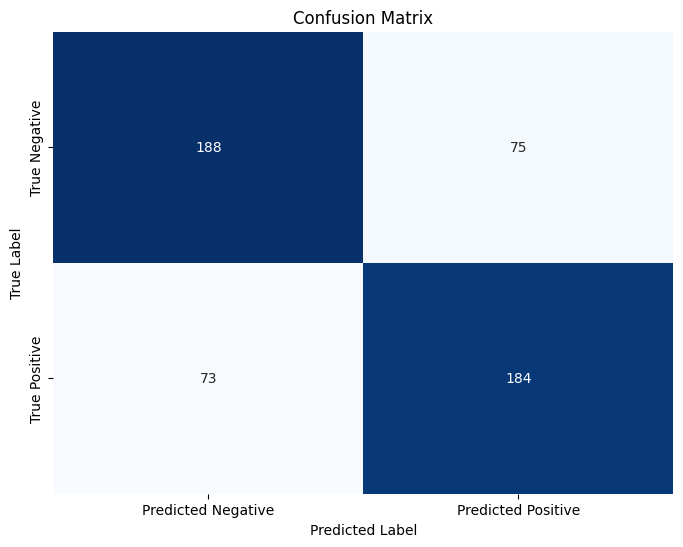

In [133]:
from sklearn.metrics import confusion_matrix

# Assuming 'test_df' contains your test data and 'test_preds' are the predictions from your model
test_preds = logr.predict(pca_test_features)  # Replace with your model's prediction method
y_true = test_df['fraudulent']  # Replace 'fraudulent' with your actual target column name

# Compute confusion matrix
cm = confusion_matrix(y_true, test_preds)

# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
